# Passes values into the trained model and compares with true sin

This notebook reads hello world models that have been saved during training. We have
* the original Tensorflow model
* the model converted to tflite
* the tflite model quantized to 8 bit integers

Get the path to the non converted model

In [8]:
import os,sys
import matplotlib.pyplot as plt
import numpy as np
from ai_edge_litert.interpreter import Interpreter
import tensorflow as tf

2025-12-17 17:25:43.033469: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
print("Python version: ",sys.version)
print("Tensorflow version: ",tf.__version__)

In [12]:
sine_model = Interpreter(model_path="models/hello_world_float.tflite")
sine_model_quantized = Interpreter(model_path="models/hello_world_int8.tflite")
# Allocate memory for each model
sine_model.allocate_tensors()
sine_model_quantized.allocate_tensors()

In [13]:
# Get the input and output tensors so we can feed in values and get the results
sine_model_input = sine_model.tensor(sine_model.get_input_details()[0]["index"])
sine_model_output = sine_model.tensor(sine_model.get_output_details()[0]["index"])
sine_model_quantized_input = sine_model_quantized.tensor(sine_model_quantized.get_input_details()[0]["index"])
sine_model_quantized_output = sine_model_quantized.tensor(sine_model_quantized.get_output_details()[0]["index"])

Now we will have to have a look at quantization in the sine_model_quantized  
First input quantization

In [14]:
input_details = sine_model_quantized.get_input_details()
print(input_details)
print(type(input_details))
input_quantization = (input_details[0]['quantization'])
input_quantization_factor = input_quantization[0]
input_quantization_zero_point = input_quantization[1]
print("Input quantization factor: ",input_quantization_factor, " zero point: ",input_quantization_zero_point)

[{'name': 'serving_default_keras_tensor:0', 'index': 0, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([-1,  1], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.02461642026901245, -128), 'quantization_parameters': {'scales': array([0.02461642], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
<class 'list'>
Input quantization factor:  0.02461642026901245  zero point:  -128


and the output quantization

In [16]:
output_details = sine_model_quantized.get_output_details()
print(output_details)
output_quantization = (output_details[0]['quantization'])
output_quantization_factor = output_quantization[0]
output_quantization_zero_point = output_quantization[1]
print("Output quantization factor: ",output_quantization_factor, " zero point: ",output_quantization_zero_point)

[{'name': 'StatefulPartitionedCall_1:0', 'index': 9, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([-1,  1], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.007994743064045906, 1), 'quantization_parameters': {'scales': array([0.00799474], dtype=float32), 'zero_points': array([1], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output quantization factor:  0.007994743064045906  zero point:  1


In [18]:
import math
print(2*math.pi/input_quantization_factor)

255.24366412808453


Generate 200 x coordinates between 0 and 2*pi as test points

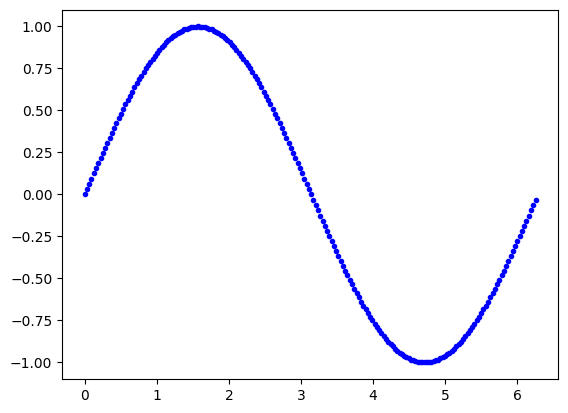

In [19]:
SAMPLES = 200
# Generate a uniformly distributed set of numbers in the range from
# 0 to 2π, which covers a complete sine wave oscillation

x_test = np.arange(2*math.pi,step=2*math.pi/SAMPLES)
# Calculate the corresponding sine values
y_test = np.sin(x_test)

# Plot our data. The 'b.' argument tells the library to print blue dots.
plt.plot(x_test, y_test, 'b.')
plt.show()

Create arrays to store the results from invocation

In [20]:
# Create arrays to store the results
sine_model_predictions = np.empty(x_test.size)
sine_model_quantized_predictions = np.empty(x_test.size)

Quantize the x values using the input quantization parameters of the quantized model

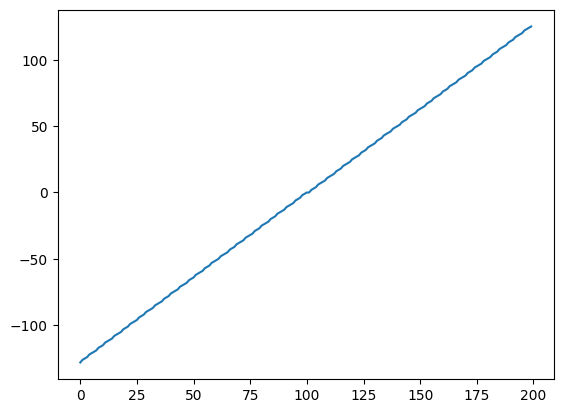

In [22]:
x_test_quantized = (x_test/input_quantization_factor + input_quantization_zero_point).astype(np.int8)
plt.plot(x_test_quantized)

This ought to give values of -127 .. +127

Invoke the interpreters with float values 0..2pi for the float model  
and -127 .. 127 for the quantized model

In [23]:
for i in range(x_test.size):
  sine_model_input().fill(x_test[i])
  sine_model.invoke()
  sine_model_predictions[i] = sine_model_output()[0][0]
  
  sine_model_quantized_input().fill(x_test_quantized[i])
  sine_model_quantized.invoke()
  sine_model_quantized_predictions[i] = sine_model_quantized_output()[0][0]

print the results from the quantized model

In [24]:
print(sine_model_quantized_predictions)

[   3.    5.   10.   11.   17.   23.   28.   27.   34.   39.   40.   47.
   47.   52.   53.   59.   64.   66.   67.   73.   80.   79.   86.   86.
   85.   92.   94.   94.   99.  101.  105.  107.  105.  109.  110.  110.
  115.  115.  117.  120.  123.  125.  120.  125.  125.  124.  126.  127.
  123.  127.  125.  127.  127.  125.  122.  120.  124.  122.  118.  119.
  119.  117.  118.  119.  114.  113.  109.  109.  105.  101.  100.   99.
   95.   92.   89.   89.   87.   81.   80.   80.   74.   70.   68.   65.
   59.   57.   53.   47.   43.   40.   37.   30.   30.   28.   23.   17.
   13.   13.    5.    1.    0.    0.   -8.  -10.  -12.  -18.  -20.  -24.
  -27.  -33.  -38.  -38.  -43.  -50.  -52.  -57.  -62.  -62.  -66.  -69.
  -72.  -76.  -79.  -81.  -84.  -86.  -88.  -93.  -96.  -96. -101. -103.
 -108. -111. -112. -113. -115. -114. -117. -117. -117. -119. -119. -120.
 -122. -120. -122. -124. -123. -125. -125. -128. -128. -128. -128. -126.
 -124. -124. -123. -121. -117. -117. -116. -115. -1

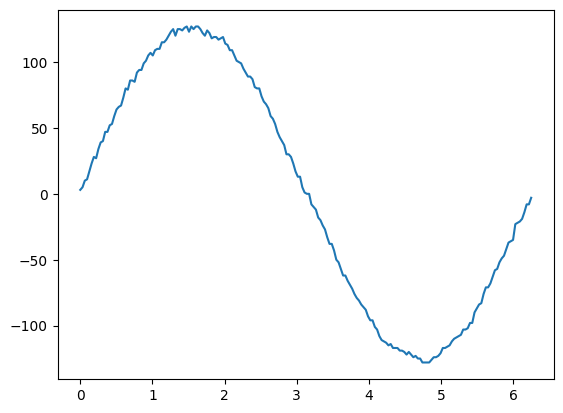

In [25]:
plt.plot(x_test,sine_model_quantized_predictions)

These values must be dequantized, which means that they are mapped onto the range -1 .. 1

In [27]:
sine_model_quantized_predictions = (sine_model_quantized_predictions + output_quantization_zero_point) * output_quantization_factor

In [ ]:
plt.plot(x_test,sine_model_quantized_predictions)

Finally, let's try the original Tensorflow model as well

In [32]:
tensorflow_sine_model = tf.keras.models.load_model("models/hello_world.keras")

In [33]:
tensorflow_sine_predictions = tensorflow_sine_model.predict(x_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


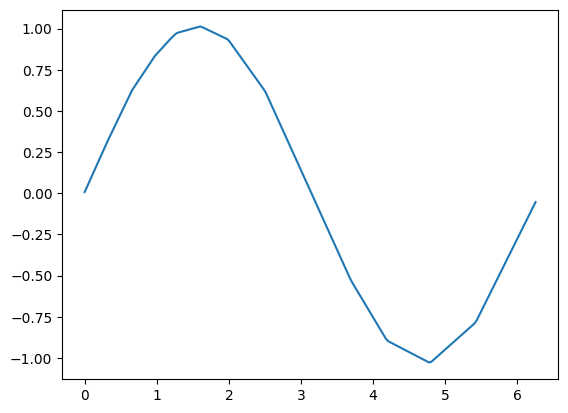

In [35]:
plt.plot(x_test,tensorflow_sine_predictions)

Finally let's compare all the results

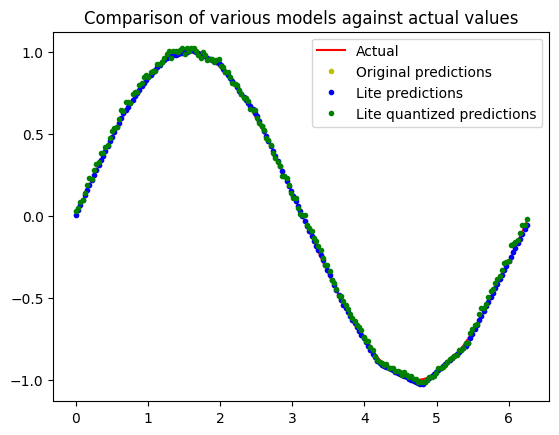

In [36]:
# See how they line up with the data
plt.clf()
plt.title('Comparison of various models against actual values')
plt.plot(x_test, y_test, 'r', label='Actual')
plt.plot(x_test, tensorflow_sine_predictions, 'y.', label='Original predictions')
plt.plot(x_test, sine_model_predictions, 'b.', label='Lite predictions')
plt.plot(x_test, sine_model_quantized_predictions, 'g.', label='Lite quantized predictions')
plt.legend()
plt.show()